# Step 2 - Creating synthetic property data for one property

In this notebook we want to create synthetic data to test our Kriging algorithms. In order to make our data viable for the different applications, we need it to meet the following requirements:
<br> 1) X,Y,Z Coordinate within the selected domain
<br> 2) Data needs to have a spatial correlation and a nugget effect
<br> 3) Later we need to create several datasets vor multiple properties, that are correlated (for CoKriging)


In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import spatial

In [2]:
# import the domain dataframe we created in step 1
domain = pd.read_csv("domain3d.csv")

In [3]:
#covariance function (using the spherical model)
def cf (h, r=400, var=0.75):
    # what exactly does the variance mean here???
    nugget=0.1
    
    if nugget <= abs(h) <= r:
        cov = var *(1-1.5*abs(h)/r+0.5*(abs(h)/r)**3)
    elif abs(h) < nugget:
        cov = 0.75 #not sure if this is correct, what to set for the nugget effect?
    else:
        cov = 0
    
    return cov

In [4]:
#SK method
def simple_kriging(point, mean, data, std):
    
    data_m = data.as_matrix(('X','Y','Z'))
    # data_v = data.as_matrix(columns='Property')
    data_v = data['Property'].values
    
    C = np.zeros((len(data_m),len(data_m)))
    c = np.zeros((len(data_m)))
    w = np.zeros((len(data_m)))
    
    for i in range(len(data_m)):
        for j in range(len(data_m)):
            C[i,j] = cf(spatial.distance.euclidean(data_m[i], data_m[j]))
                     
        c[i] = cf(spatial.distance.euclidean(data_m[i], point))
    
    w = np.linalg.solve(C,c)
    
    result = np.random.normal(mean, scale=std) + sum(w*(data_v - mean))
    
    return result

In [5]:
def create_synthetic_Input_data(n_samples, grid, mean, std):
    '''
    This Part is used to create synthetic Input data. It is possible to vary the number of properties
    and the number of samples. Right now every assigned value is a random value between 0 and 100.
    Data is thus in no way spatially correlated, which makes the Kriging kind of useless, but works for
    testing purposes. Only an isotopic case is realized. Max 10 properties can be used due to a.
    Args: 
        n_prop (int): Number of properties that we have data for
        n_samples (int): Number of sample locations, were we have data for every property (isotopic)
        grid (pandas.dataframe): grid from which the coordinates for the data points are taken
    Returns:
        df_prop(pandas.dataframe): dataframe containing x,y,z coordinates and data for n properties
    '''
    # this case only for one property
    n_prop = 1
    # copy to leave original grid intact
    data_loc_aux = grid.copy()

    # create dataframe with coordinates and n properties
    d = ['X', 'Y', 'Z', 'Property']
    df_prop = pd.DataFrame(columns=d)
    
    for i in range(n_samples):
            # choose random point from df_sgs_grid_calc
            rand_pos = np.random.randint(0,len(data_loc_aux))
            random_coord = np.array([data_loc_aux.loc[rand_pos,'X'],data_loc_aux.loc[rand_pos,'Y'],data_loc_aux.loc[rand_pos,'Z']])
            
            # delete point from the df sgs_grid_calc
            data_loc_aux = data_loc_aux.drop([rand_pos])
            data_loc_aux = data_loc_aux.reset_index() # reset indicies
            del data_loc_aux['index'] #reset indices
            
            # pick random coordinate from grid
            data_point=([random_coord[0], random_coord[1], random_coord[2]])
            
            if df_prop.empty:
                # create starting point
                data_value = np.random.normal(mean, scale=std)
            else:
                # create a value based on covariance function
                # mean, std = kriging()
                data_value = simple_kriging(data_point, mean, df_prop, std)
            
            # add calculated data value
            data_point.append(data_value)
        
            # put it into the dataframe
            df_prop.loc[i]=data_point

    return df_prop

In [6]:
data = create_synthetic_Input_data(n_samples=200, grid=domain, mean=20, std=5)

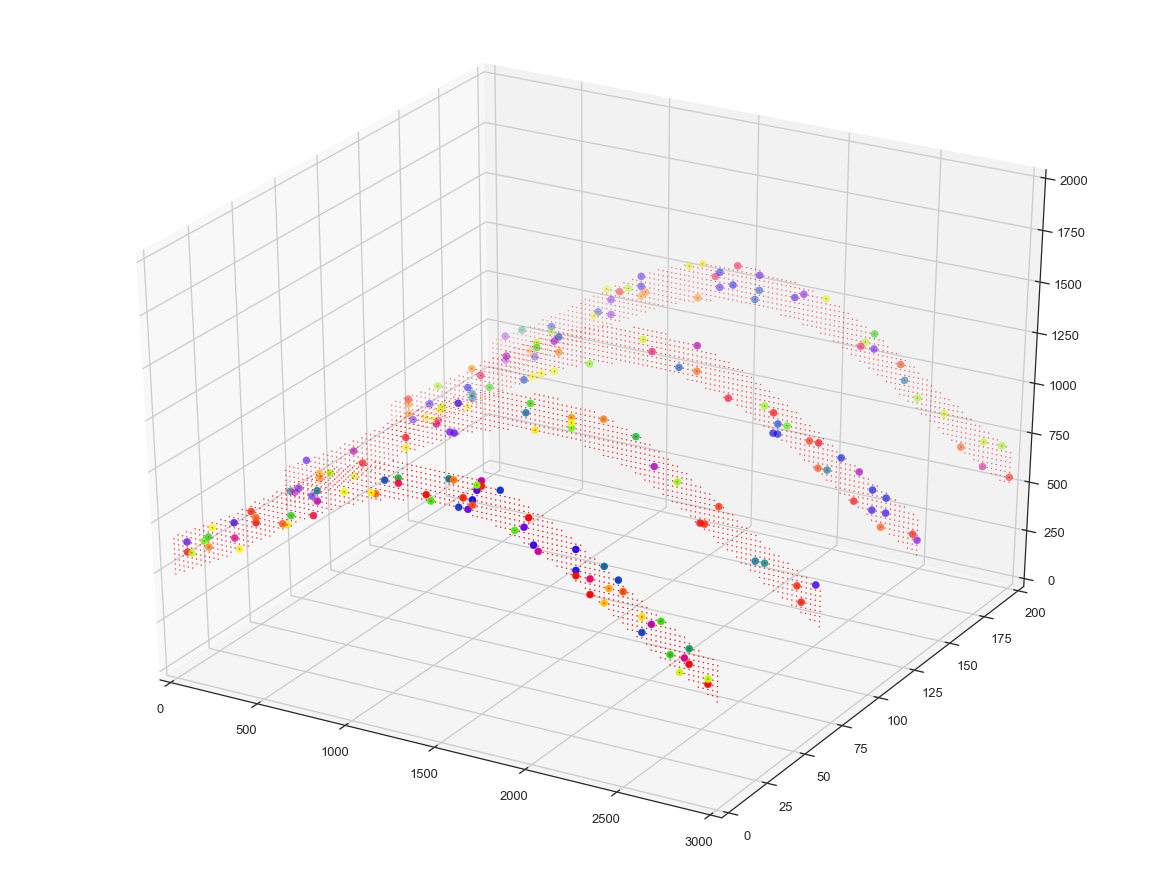

In [7]:
fig = plt.figure(figsize=(16,12))
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=domain.X,ys=domain.Y,zs=domain.Z, c='red', s=1)
ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, cmap='prism')

In [8]:
data.to_csv("data3d.csv", index=False)